##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Lite でのオンデバイストレーニング

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/lite/examples/on_device_training/overview">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/lite/examples/on_device_training/overview.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Google Colab で実行</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/lite/examples/on_device_training/overview.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/lite/examples/on_device_training/overview.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

TensorFlow Lite*{nbsp}*機械学習モデルをデバイスまたはモバイルアプリにデプロイするときには、デバイスまたはエンドユーザーの入力に基づいて、モデルを改良またはパーソナル化したい場合があります。オンデバイストレーニング手法を使用すると、データをユーザーのデバイスから移動させずにモデルを更新できます。これにより、ユーザープライバシーが強化され、ユーザーはデバイスソフトウェアを更新する必要がありません。

たとえば、モバイルアプリでファッションアイテムを認識するモデルがあり、ユーザーの関心に基づいて経時的に認識パフォーマンスを改善させたいとします。オンデバイストレーニングを有効にすると、靴に関心があるユーザーは、アプリを使用するほど、特定の靴のスタイルや靴ブランドの認識能力が高くなります。

このチュートリアルでは、インストールされた Android アプリ内で、増分的にトレーニング、改善できる TensorFlow Lite モデルを構築する方法について説明します。

注意: 対象のデバイスでローカルファイルストレージがサポートされている場合は、オンデバイストレーニング手法を既存の TensorFlow Lite 実装に追加できます。


## 設定

このチュートリアルでは、Python を使用して、TensorFlow モデルをトレーニング、変換します。その後に、Android アプリに統合します。まず、次のパッケージをインストールしてインポートします。

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


注意: On-Device Training API は TensorFlow バージョン 2.7 以上で提供されています。

## 服飾の画像を分類する

このサンプルコードでは、[Fashion MNIST データセット](https://keras.io/api/datasets/fashion_mnist/)を使用して、服飾の画像を分類するニュートラルネットワークモデルをトレーニングします。このデータセットには、 6 万個の小さい (28 x 28 ピクセル) グレースケール画像が含まれています。画像には、ドレス、シャツ、サンダルなどの 10 種類のファッションアクセサリのカテゴリがあります。

&lt;figure&gt;
  &lt;img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
       alt="Fashion MNIST images"&gt;
  &lt;figcaption&gt;&lt;b&gt;Figure 1&lt;/b&gt;: &lt;a href="https://github.com/zalandoresearch/fashion-mnist"&gt;Fashion-MNIST samples&lt;/a&gt; (by Zalando, MIT License).&lt;/figcaption&gt;
&lt;/figure&gt;

&lt;figure&gt;
&lt;img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
alt="Fashion MNIST images"&gt;
&lt;figcaption&gt;&lt;b&gt;Figure 1&lt;/b&gt;: &lt;a href="https://github.com/zalandoresearch/fashion-mnist"&gt;Fashion-MNIST samples&lt;/a&gt; (by Zalando, MIT License).&lt;/figcaption&gt;
&lt;/figure&gt;

## オンデバイストレーニングのモデルを作成する

一般的に、TensorFlow Lite モデルには、公開された関数メソッド ([シグネチャ](https://www.tensorflow.org/lite/guide/signatures)) が 1 つだけあり、それによってモデルを呼び出して推論を実行できます。デバイスでモデルをトレーニングして使用するには、モデルのトレーニング、推論、保存、復元関数といった、複数の個別の演算を実行できる必要があります。この機能を有効にするには、まず、複数の関数を使用できるように TensorFlow モデルを拡張します。次に、モデルを TensorFlow Lite モデル形式に変換するときに、これらの関数をシグネチャとして公開します。

次のコードサンプルは、次の関数を TensorFlow モデルに追加する方法について説明します。

- `train` 関数: トレーニングデータを使用してモデルをトレーニングします。
- `infer` 関数: 推論を実行します。
- `save` 関数: トレーニング可能な重みをファイルシステムに保存します。
- `restore` 関数: トレーニング可能な重みをファイルシステムから読み込みます。

In [ ]:
IMG_SIZE = 28

class Model(tf.Module):

  def __init__(self):
    self.model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE), name='flatten'),
        tf.keras.layers.Dense(128, activation='relu', name='dense_1'),
        tf.keras.layers.Dense(10, name='dense_2')
    ])

    self.model.compile(
        optimizer='sgd',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True))

  # The `train` function takes a batch of input images and labels.
  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
      tf.TensorSpec([None, 10], tf.float32),
  ])
  def train(self, x, y):
    with tf.GradientTape() as tape:
      prediction = self.model(x)
      loss = self.model.loss(y, prediction)
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.model.optimizer.apply_gradients(
        zip(gradients, self.model.trainable_variables))
    result = {"loss": loss}
    return result

  @tf.function(input_signature=[
      tf.TensorSpec([None, IMG_SIZE, IMG_SIZE], tf.float32),
  ])
  def infer(self, x):
    logits = self.model(x)
    probabilities = tf.nn.softmax(logits, axis=-1)
    return {
        "output": probabilities,
        "logits": logits
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def save(self, checkpoint_path):
    tensor_names = [weight.name for weight in self.model.weights]
    tensors_to_save = [weight.read_value() for weight in self.model.weights]
    tf.raw_ops.Save(
        filename=checkpoint_path, tensor_names=tensor_names,
        data=tensors_to_save, name='save')
    return {
        "checkpoint_path": checkpoint_path
    }

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def restore(self, checkpoint_path):
    restored_tensors = {}
    for var in self.model.weights:
      restored = tf.raw_ops.Restore(
          file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
          name='restore')
      var.assign(restored)
      restored_tensors[var.name] = restored
    return restored_tensors

上記のコードの `train` 関数は [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) クラスを使用して、自動微分の演算を記録します。このクラスの使用方法の詳細については、[勾配と自動微分の概要](https://www.tensorflow.org/guide/autodiff)を参照してください。

ここでは、ゼロから実装するのではなく、keras モデルの `Model.train_step` メソッドを使用できます。`Model.train_step` によって返される損失 (およびメトリクス) は移動平均であり、定期的に (通常はエポックごとに) リセットしてください。詳細については、[Model.fit のカスタマイズ](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit)を参照してください。

注意: このモデルで生成される重みは、TensorFlow 1 形式のチェックポイントファイルにシリアル化されます。

## データを準備する

モデルをトレーニングするための Fashion MNIST データセットを取得します。

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

### データの前処理

このデータセットのピクセル値は、0 ～ 255 です。この値をモデルで処理するためには、0 ～ 1 の範囲の値に正規化する必要があります。値を 255 で除算すると、正規化できます。

In [ ]:
train_images = (train_images / 255.0).astype(np.float32)
test_images = (test_images / 255.0).astype(np.float32)

ワンホットエンコーディングを実行して、データラベルをカテゴリ値に変換します。

In [ ]:
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

注意:**{nbsp}**必ずトレーニングデータセットとテストデータセットは同じ方法で前処理し、テストでモデルのパフォーマンスを正確に評価できるようにしてください。

## モデルのトレーニング

TensorFlow Lite モデルを変換、設定する前に、前処理済みのデータセットと `train` シグネチャを使用して、モデルの初期トレーニングを完了します。次のコードは 100 エポックでモデルトレーニングを実行して、100 個の画像のバッチを一度に処理し、10 エポックごとに損失値を表示します。このトレーニング実行ではかなりのデータが処理されるため、完了するのに数分かかる場合があります。


In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 100
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])
m = Model()

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.batch(BATCH_SIZE)

for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = m.train(x, y)

  losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {losses[i]:.3f}")

# Save the trained weights to a checkpoint.
m.save('/tmp/model.ckpt')

Finished 10 epochs
  loss: 0.428
Finished 20 epochs
  loss: 0.378
Finished 30 epochs
  loss: 0.344
Finished 40 epochs
  loss: 0.317
Finished 50 epochs
  loss: 0.299
Finished 60 epochs
  loss: 0.283
Finished 70 epochs
  loss: 0.266
Finished 80 epochs
  loss: 0.252
Finished 90 epochs
  loss: 0.240
Finished 100 epochs
  loss: 0.230


{'checkpoint_path': <tf.Tensor: shape=(), dtype=string, numpy=b'/tmp/model.ckpt'>}

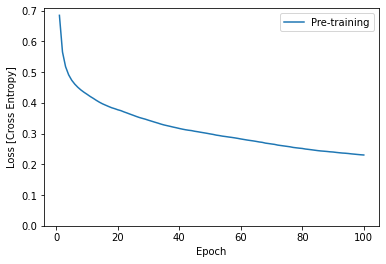

In [ ]:
plt.plot(epochs, losses, label='Pre-training')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

注意: TensorFlow Lite 形式に変換する前に、モデルの初期トレーニングを完了してください。これにより、モデルに重みの初期セットが追加され、データの収集と、デバイスでのトレーニングの実行を開始する前に、合理的な推論を実行できます。

## モデルを TensorFlow Lite 形式に変換する

TensorFlow モデルを拡張して、オンデバイストレーニングの追加の関数を有効にし、モデルの初期トレーニングを完了した後は、そのモデルを TensorFlow Lite モデルに変換できます。次のコードは、デバイスで Tensorflow Lite モデルを変換し、モデルとともに使用するシグネチャのセットを含む形式にモデルを保存します。`train, infer, save, restore`

In [ ]:
SAVED_MODEL_DIR = "saved_model"

tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        'infer':
            m.infer.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

### TensorFlow Lite シグネチャを設定する

前のステップで保存した TensorFlow Lite モデルには、複数の関数シグネチャが含まれます。`tf.lite.Interpreter` クラス経由でシグネチャにアクセスし、それぞれ個別に `restore`、`train`、`save`、`infer` シグネチャを呼び出すことができます。

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

infer = interpreter.get_signature_runner("infer")

元のモデルの出力と、変換された Lite モデルを比較します。

In [ ]:
logits_original = m.infer(x=train_images[:1])['logits'][0]
logits_lite = infer(x=train_images[:1])['logits'][0]

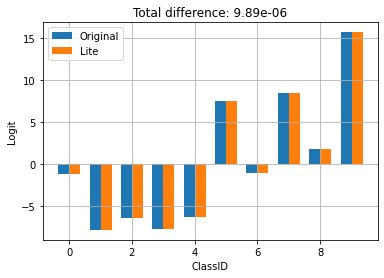

In [ ]:
#@title
def compare_logits(logits):
  width = 0.35
  offset = width/2
  assert len(logits)==2

  keys = list(logits.keys())
  plt.bar(x = np.arange(len(logits[keys[0]]))-offset,
      height=logits[keys[0]], width=0.35, label=keys[0])
  plt.bar(x = np.arange(len(logits[keys[1]]))+offset,
      height=logits[keys[1]], width=0.35, label=keys[1])
  plt.legend()
  plt.grid(True)
  plt.ylabel('Logit')
  plt.xlabel('ClassID')

  delta = np.sum(np.abs(logits[keys[0]] - logits[keys[1]]))
  plt.title(f"Total difference: {delta:.3g}")

compare_logits({'Original': logits_original, 'Lite': logits_lite})

上記では、モデルの動作が TFLite への変換によって変わっていないことを確認できます。

## デバイスでモデルを再トレーニングする

モデルを Tensorflow Lite に変換し、アプリでデプロイした後は、新しいデータとモデルの `train` シグネチャ<br>メソッドを使用して、デバイスでモデルを再トレーニングできます。各トレーニング実行では、新しい重みのセットが生成されます。次のセクションで示すように、重みを保存すると、再利用したり、モデルのさらなる改善で使用できます。

注意: トレーニングタスクはリソースの消費量が大きいため、ユーザーがデバイスを操作していないときに実行するか、バックグラウンドプロセスとして実行することを検討してください。また、[WorkManager](https://developer.android.com/topic/libraries/architecture/workmanager) API を使用して、非同期タスクとしてモデルの再トレーニングをスケジュールすることを検討してください。

Android では、Java API または C + + API を使用して、TensorFlow Lite でオンデバイストレーニングを実行できます。Java では、`Interpreter`クラスを使用して、モデルを読み込み、モデルトレーニングタスクを実行します。次の例では、`runSignature` メソッドを使用したトレーニング手順を実行する方法について示します。


```Java
try (Interpreter interpreter = new Interpreter(modelBuffer)) {
    int NUM_EPOCHS = 100;
    int BATCH_SIZE = 100;
    int IMG_HEIGHT = 28;
    int IMG_WIDTH = 28;
    int NUM_TRAININGS = 60000;
    int NUM_BATCHES = NUM_TRAININGS / BATCH_SIZE;

    List<FloatBuffer> trainImageBatches = new ArrayList<>(NUM_BATCHES);
    List<FloatBuffer> trainLabelBatches = new ArrayList<>(NUM_BATCHES);

    // Prepare training batches.
    for (int i = 0; i < NUM_BATCHES; ++i) {
        FloatBuffer trainImages = FloatBuffer.allocateDirect(BATCH_SIZE * IMG_HEIGHT * IMG_WIDTH).order(ByteOrder.nativeOrder());
        FloatBuffer trainLabels = FloatBuffer.allocateDirect(BATCH_SIZE * 10).order(ByteOrder.nativeOrder());

        // Fill the data values...
        trainImageBatches.add(trainImages.rewind());
        trainImageLabels.add(trainLabels.rewind());
    }

    // Run training for a few steps.
    float[] losses = new float[NUM_EPOCHS];
    for (int epoch = 0; epoch < NUM_EPOCHS; ++epoch) {
        for (int batchIdx = 0; batchIdx < NUM_BATCHES; ++batchIdx) {
            Map<String, Object> inputs = new HashMap<>();
            inputs.put("x", trainImageBatches.get(batchIdx));
            inputs.put("y", trainLabelBatches.get(batchIdx));

            Map<String, Object> outputs = new HashMap<>();
            FloatBuffer loss = FloatBuffer.allocate(1);
            outputs.put("loss", loss);

            interpreter.runSignature(inputs, outputs, "train");

            // Record the last loss.
            if (batchIdx == NUM_BATCHES - 1) losses[epoch] = loss.get(0);
        }

        // Print the loss output for every 10 epochs.
        if ((epoch + 1) % 10 == 0) {
            System.out.println(
              "Finished " + (epoch + 1) + " epochs, current loss: " + loss.get(0));
        }
    }

    // ...
}
```


[モデルパーソならぜーションデモアプリ](https://github.com/tensorflow/examples/blob/master/lite/examples/model_personalization/android/transfer_api/src/main/java/org/tensorflow/lite/examples/transfer/api/LiteMultipleSignatureModel.java)では、Android アプリ内に保持されているモデルのコードサンプル全体を確認できます。

2、3 エポック分のトレーニングを実行し、モデルを改善またはパーソナライズします。実際には、デバイスで収集されたデータを使用して、この追加トレーニングを実行してください。簡潔にするために、この例では、前のトレーニングステップと同じトレーニングデータを使用しています。

In [ ]:
train = interpreter.get_signature_runner("train")

NUM_EPOCHS = 50
BATCH_SIZE = 100
more_epochs = np.arange(epochs[-1]+1, epochs[-1] + NUM_EPOCHS + 1, 1)
more_losses = np.zeros([NUM_EPOCHS])


for i in range(NUM_EPOCHS):
  for x,y in train_ds:
    result = train(x=x, y=y)
  more_losses[i] = result['loss']
  if (i + 1) % 10 == 0:
    print(f"Finished {i+1} epochs")
    print(f"  loss: {more_losses[i]:.3f}")

Finished 10 epochs
  loss: 0.223
Finished 20 epochs
  loss: 0.216
Finished 30 epochs
  loss: 0.210
Finished 40 epochs
  loss: 0.204
Finished 50 epochs
  loss: 0.198


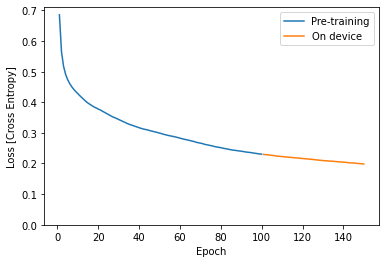

In [ ]:
plt.plot(epochs, losses, label='Pre-training')
plt.plot(more_epochs, more_losses, label='On device')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

上記では、事前トレーニングが停止した正確な位置からオンデバイストレーニングが開始することを確認できます。

## トレーニングされた重みの保存

デバイスでトレーニングの実行を完了すると、メモリで使用されていた重みのセットがモデルで更新されます。TensorFlow Lite モデルで作成した `save` シグネチャメソッドを使用すると、これらの重みをチェックポイントファイルに保存して、後から再利用したり、モデルを改善したりできます。

In [ ]:
save = interpreter.get_signature_runner("save")

save(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

{'checkpoint_path': array(b'/tmp/model.ckpt', dtype=object)}

Android アプリケーションでは、アプリに割り当てられた内部ストレージ領域にあるチェックポイントファイルとして、生成された重みを保存できます。

```Java
try (Interpreter interpreter = new Interpreter(modelBuffer)) {
    // Conduct the training jobs.

    // Export the trained weights as a checkpoint file.
    File outputFile = new File(getFilesDir(), "checkpoint.ckpt");
    Map&lt;String, Object&gt; inputs = new HashMap&lt;&gt;();
    inputs.put("checkpoint_path", outputFile.getAbsolutePath());
    Map&lt;String, Object&gt; outputs = new HashMap&lt;&gt;();
    interpreter.runSignature(inputs, outputs, "save");
}
```

## トレーニングされた重みの復元

TFLite モデルからインタープリタを作成するたびに、インタープリタでは最初に元のモデルの重みが読み込まれます。

トレーニングを実行し、チェックポイントファイルを保存した後は、`restore` シグネチャメソッドを使用して、チェックポイントを読み込む必要があります。

「チェックポイントが存在する場合は、モデルのインタープリタを作成するたびに読み込む」というルールを設定しておくことをお勧めします。モデルをベースラインの動作にリセットする必要がある場合は、チェックポイントを削除し、新しい<br>インタープリタを作成します。


In [ ]:
another_interpreter = tf.lite.Interpreter(model_content=tflite_model)
another_interpreter.allocate_tensors()

infer = another_interpreter.get_signature_runner("infer")
restore = another_interpreter.get_signature_runner("restore")

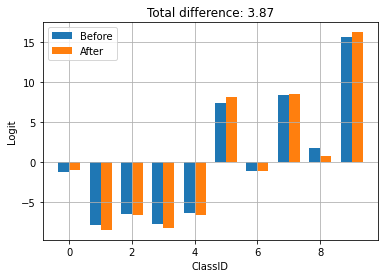

In [ ]:
logits_before = infer(x=train_images[:1])['logits'][0]

# Restore the trained weights from /tmp/model.ckpt
restore(checkpoint_path=np.array("/tmp/model.ckpt", dtype=np.string_))

logits_after = infer(x=train_images[:1])['logits'][0]

compare_logits({'Before': logits_before, 'After': logits_after})

チェックポイントは、TFLite によるトレーニングと保存によって生成されます。上記では、チェックポイントを適用すると、モデルの動作が更新されることが確認できます。

注意: モデルの変数の数とチェックポイントのサイズによっては、チェックポイントから保存された重みを読み込むときに時間がかかります。


Android アプリでは、シリアル化されたトレーニング済みの重みを、前に保存したチェックポイントファイルから復元できます。

```Java
try (Interpreter anotherInterpreter = new Interpreter(modelBuffer)) {
    // Load the trained weights from the checkpoint file.
    File outputFile = new File(getFilesDir(), "checkpoint.ckpt");
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("checkpoint_path", outputFile.getAbsolutePath());
    Map<String, Object> outputs = new HashMap<>();
    anotherInterpreter.runSignature(inputs, outputs, "restore");
}
```

注意: アプリケーションが再起動するときには、新しい推論を実行する前に、トレーニング済みの重みを再読み込みしてください。

## トレーニング済みの重みを使用した推論の実行

以前に保存した重みをチェックポイントから読み込んだ後、`infer` メソッドを実行すると、これらの重みと元のモデルが使用され、予測を改善します。保存された重みを読み込んだ後は、次のように、`infer` シグネチャメソッドを使用できます。

注意: 推論を実行するために保存された重みを読み込む必要はありません。ただし、その構成で実行すると、最初にトレーニングされたモデルを使用して、改善を行わずに、予測が生成されます。

In [ ]:
infer = another_interpreter.get_signature_runner("infer")
result = infer(x=test_images)
predictions = np.argmax(result["output"], axis=1)

true_labels = np.argmax(test_labels, axis=1)

In [ ]:
result['output'].shape

(10000, 10)

予測されたラベルをプロットします。

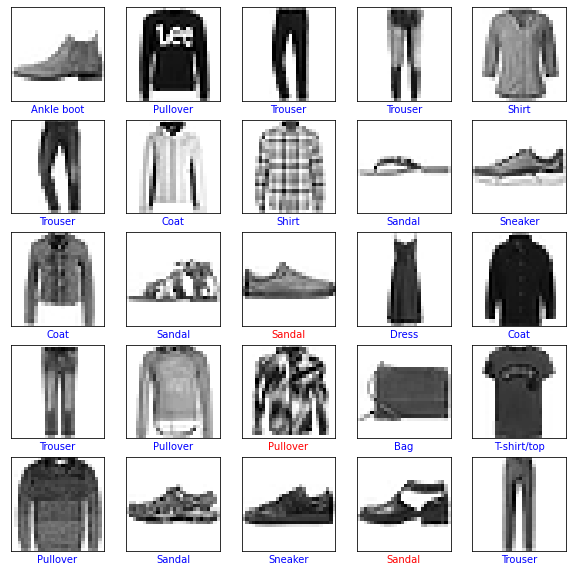

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def plot(images, predictions, true_labels):
  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      color = 'b' if predictions[i] == true_labels[i] else 'r'
      plt.xlabel(class_names[predictions[i]], color=color)
  plt.show()

plot(test_images, predictions, true_labels)

In [ ]:
predictions.shape

(10000,)

Android アプリケーションで、トレーニング済みの重みを復元した後に、読み込まれたデータに基づいて推論を実行します。

```Java
try (Interpreter anotherInterpreter = new Interpreter(modelBuffer)) {
    // Restore the weights from the checkpoint file.

    int NUM_TESTS = 10;
    FloatBuffer testImages = FloatBuffer.allocateDirect(NUM_TESTS * 28 * 28).order(ByteOrder.nativeOrder());
    FloatBuffer output = FloatBuffer.allocateDirect(NUM_TESTS * 10).order(ByteOrder.nativeOrder());

    // Fill the test data.

    // Run the inference.
    Map<String, Object> inputs = new HashMap<>();
    inputs.put("x", testImages.rewind());
    Map<String, Object> outputs = new HashMap<>();
    outputs.put("output", output);
    anotherInterpreter.runSignature(inputs, outputs, "infer");
    output.rewind();

    // Process the result to get the final category values.
    int[] testLabels = new int[NUM_TESTS];
    for (int i = 0; i < NUM_TESTS; ++i) {
        int index = 0;
        for (int j = 1; j < 10; ++j) {
            if (output.get(i * 10 + index) < output.get(i * 10 + j)) index = testLabels[j];
        }
        testLabels[i] = index;
    }
}
```

これで、オンデバイストレーニングをサポートする TensorFlow Lite モデルを構築できました。詳細については、[モデルパーソナライゼーションデモアプリ](https://github.com/tensorflow/examples/tree/master/lite/examples/model_personalization)の実装例を確認してください。

画像分類の詳細については、TensorFlow 公式ガイドページの [Keras 分類チュートリアル](https://www.tensorflow.org/tutorials/keras/classification)を確認してください。このチュートリアルは、その演習に基づいていて、分類のテーマを掘り下げて行きます。
